In [17]:
import os, sys

# Get the absolute path of the notebook's directory
notebook_dir = os.getcwd()

# Navigate to the parent directory
parent_dir = os.path.abspath(os.path.join(notebook_dir, ".."))

# Add the parent directory to sys.path so we can import modules
sys.path.append(parent_dir)

# Verify the path
print(f"Added to sys.path: {parent_dir}")

# Add it to sys.path
sys.path.append(parent_dir)

print(parent_dir)
from localityaware.module import *
from NSGA_nn.nsga import *
from BNH import *

Added to sys.path: /Users/panwapromtep/Library/CloudStorage/OneDrive-JohnsHopkins/Process Design/Aspen
/Users/panwapromtep/Library/CloudStorage/OneDrive-JohnsHopkins/Process Design/Aspen


In [18]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import time
from scipy.stats import qmc

BNH_sim = BNHWrapper()

Elapsed time: 0.00 seconds


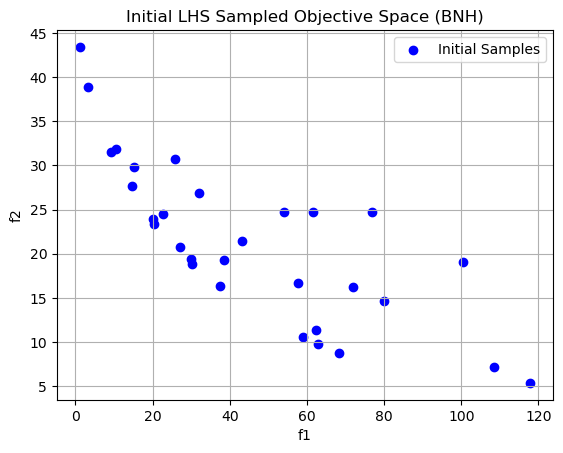

In [19]:
# elapsed      = time spent generating initial samples

# ---- Config ----
N = 30         # Number of LHS samples
seed = 42      # Reproducibility
xl = np.array([0.0, 0.0])
xu = np.array([5.0, 3.0])

# ---- Latin Hypercube Sampling ----
sampler = qmc.LatinHypercube(d=2, seed=seed)
X_unit = sampler.random(n=N)
X_scaled = qmc.scale(X_unit, xl, xu)

# ---- Evaluate using BNHWrapper ----
F_vals = []
X_vals = []
start_time = time.time()
for x in X_scaled:
    f = BNH_sim.run_obj(x)
    F_vals.append(f)
    X_vals.append(x)

X_vals = np.array(X_vals)
F_vals = np.array(F_vals)
data_gen_time  = time.time() - start_time
print(f"Elapsed time: {data_gen_time :.2f} seconds")

# ---- Optional: Save to dataset for surrogate ----
# Format: columns = [x1, x2, f1, f2]
initial_dataset = np.hstack([X_vals, F_vals])
np.save("bnh_initial_dataset.npy", initial_dataset)

# ---- Optional: Visualization ----
plt.scatter(F_vals[:, 0], F_vals[:, 1], c='blue', label='Initial Samples')
plt.xlabel("f1")
plt.ylabel("f2")
plt.title("Initial LHS Sampled Objective Space (BNH)")
plt.grid(True)
plt.legend()
plt.show()

# ---- Optional: Torch conversion ----
X_tensor = torch.tensor(X_vals, dtype=torch.float32)
Y_tensor = torch.tensor(F_vals, dtype=torch.float32)

data_sim = initial_dataset  # shape (N, 4): [x1, x2, f1, f2]


Text(0.5, 1.0, 'Initial LHS Sampled Input Space (BNH)')

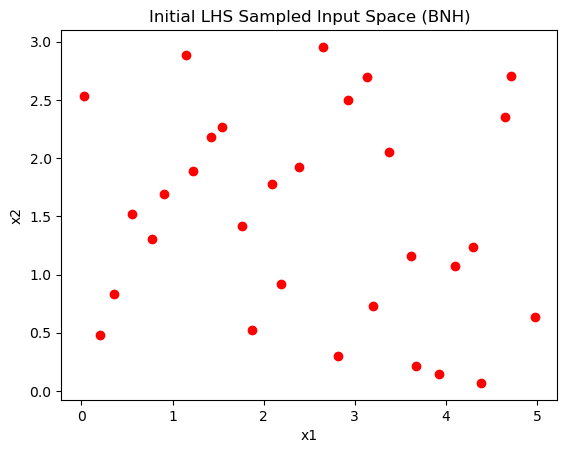

In [20]:
# plot the 2 inputs
plt.scatter(X_tensor[:, 0], X_tensor[:, 1], c='red', label='Initial Samples')
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Initial LHS Sampled Input Space (BNH)")

In [21]:
import numpy as np
import torch

# Assume `data_sim` is your list of [x1, x2, f1, f2] rows, converted to an array:
#   data_sim.shape == (N, 4)
data_sim = np.array(data_sim)  

print("Number of samples collected:", data_sim.shape[0])

# --- Split into inputs (2 cols) and outputs (2 cols) ---
X_raw = data_sim[:, :2]   # x1, x2
Y_raw = data_sim[:, 2:]   # f1, f2

# --- Auto-detect output ranges for scaling ---
min_y = Y_raw.min(axis=0).tolist()   # [min(f1), min(f2)]
max_y = Y_raw.max(axis=0).tolist()   # [max(f1), max(f2)]

print("Output ranges:", dict(min_y=min_y, max_y=max_y))

# --- Scaler for 2 inputs and 2 outputs ---
scaler = TorchMinMaxScaler(
    feature_range=(-1, 1),
    min_vals=[0.0, 0.0],    # BNH x1 ∈ [0,5], x2 ∈ [0,3]
    max_vals=[5.0, 3.0],
    scale_y=True,
    min_y=min_y,
    max_y=max_y
)

# --- Scale ---
X_scaled_t, Y_scaled_t = scaler.transform(X_raw, Y_raw)
# Convert back to numpy
X_scaled = X_scaled_t.detach().cpu().numpy()
Y_scaled = Y_scaled_t.detach().cpu().numpy()

# --- Combine back into one array if needed ---
data_scaled = np.hstack([X_scaled, Y_scaled])
print("Scaled data shape:", data_scaled.shape)
print("First 5 rows:\n", data_scaled[:5])

# --- Initialize your surrogate dataset & model ---
dataset = DynamicDataset(data_scaled, num_inputs=2)
model   = MLP(2, [50, 50, 50,50, 50, 50], 2)  # input_dim=2, output_dim=2

print("✅ Dataset and model initialized for BNH (2 inputs → 2 outputs).")


Number of samples collected: 30
Output ranges: {'min_y': [1.0894762059476213, 5.359626004780381], 'max_y': [117.93671738333259, 43.43098025446181]}
Scaled data shape: (30, 4)
First 5 rows:
 [[ 0.34840298  0.37074137  0.0488168  -0.68687916]
 [-0.85723984 -0.44649118 -0.9627311   0.7643424 ]
 [ 0.12705493 -0.79837483 -0.46883273  0.12789118]
 [-0.2507426  -0.6524043  -0.759813    0.285771  ]
 [ 0.05812573  0.96997416  0.05827856 -0.77058333]]
✅ Dataset and model initialized for BNH (2 inputs → 2 outputs).


In [22]:
from BNH import SurrogateBNHProblem
problem = SurrogateBNHProblem(
    model=model,
    scaler=scaler,
    device = "cpu",
)

In [23]:
# 6) Run the surrogate‑assisted NSGA‑II loop

from pymoo.problems.multi import BNH

out = optimize_surr_nsga(
    model=model,
    dataset=dataset,
    assSim=BNH_sim,
    problem=problem,
    lrs={'first': 1e-4, 'others': 1e-4},
    epochs={'first': 3000, 'others': 600},
    scaler=scaler,
    device='cpu',
    iter=10,
    pop_size=1000,
    n_gen=2,
    new_data_size=10,
    batch_size=128,
    print_loss=False,
    print_it_data=True
)

print("Done. Total Aspen calls:", out['assSim_call_count'])

Iteration 0: Training surrogate model...
n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |     1000 |    168 |  0.000000E+00 |  0.1399537888 |             - |             -
     2 |     2000 |    252 |  0.000000E+00 |  0.000000E+00 |  0.0029052233 |         ideal
assSim_call_count: 10
Iteration 0: Added 10 points, dataset size (40, 4)
dataset.data.shape: (40, 4)
Iteration 1: Training surrogate model...
n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |     1000 |    255 |  0.000000E+00 |  0.000000E+00 |             - |             -
     2 |     2000 |    351 |  0.000000E+00 |  0.000000E+00 |  0.0034254934 |         ideal
assSim_call_count: 20
Iteration 1: Added 10 points, dataset size (50, 4)
dataset.data.shape: (50, 4)
Iteration 2: Training surrogate model...
n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |     1000 |    353 |  0.000000

In [24]:
import os
import datetime
import pickle
import numpy as np

# ---- Record timing / call stats ----
# (define these earlier in your script)
# elapsed      = time spent generating initial samples
# out['assSim_call_count'] set by optimize_surr_nsga  
total_assim_calls = out.get('assSim_call_count', 0)

# ---- Experiment naming ----
notebook_name = "bnh" 
now = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# ---- Make save directory ----
base_dir = os.path.join("results", notebook_name)
save_dir = os.path.join(base_dir, f"run_{now}")
os.makedirs(save_dir, exist_ok=True)
print(f"Results will be saved in: {save_dir}")

# ---- Save optimization output ----
out["data_gen_time"] = data_gen_time
out["total_assim_calls"] = total_assim_calls
out["total_original_assSim_calls"] = N
with open(os.path.join(save_dir, "out.pkl"), "wb") as f:
    pickle.dump(out, f)

# ---- Save scaler ----
with open(os.path.join(save_dir, "scaler.pkl"), "wb") as f:
    pickle.dump(scaler, f)

# ---- Save dataset object ----
with open(os.path.join(save_dir, "dataset.pkl"), "wb") as f:
    pickle.dump(dataset, f)

# ---- Save initial LHS dataset if you have it ----
# initial_dataset = np.hstack([X_vals, F_vals])
if 'initial_dataset' in globals():
    np.save(os.path.join(save_dir, "initial_dataset.npy"), initial_dataset)

print(f"✅ All BNH run artifacts saved under {save_dir}")


Results will be saved in: results/bnh/run_2025-04-20_15-57-53
✅ All BNH run artifacts saved under results/bnh/run_2025-04-20_15-57-53
